<a href="https://colab.research.google.com/github/Ksenia-90/Machine_learning-_in_business/blob/lesson_9/news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ИТОГОВЫЙ ПРОЕКТ**
##**Тема: Fake-and-real-news**
### Предсказать по описанию новости является ли она фейком или нет (поле target)

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import pandas as pd
import dill
import numpy as np
import urllib.request
import json  
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score,recall_score
from sklearn import metrics
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [75]:
df_f = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake.csv")
df_f['target'] = 'fake'
df_t = pd.read_csv("/content/drive/My Drive/Colab Notebooks/True.csv")
df_t['target'] = 'true'

In [76]:
df_f.shape

(23481, 5)

In [77]:
df_t.shape

(21417, 5)

In [78]:
df = pd.concat([df_f, df_t]).reset_index(drop = True)

In [79]:
df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [80]:
df.shape

(44898, 5)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [82]:
df['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east', 'politicsNews', 'worldnews'], dtype=object)

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


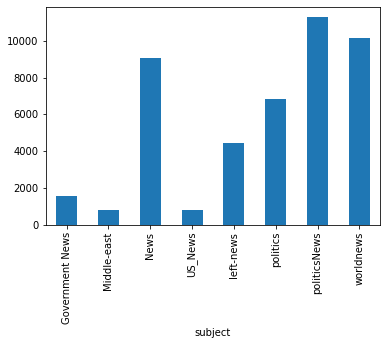

In [83]:
print(df.groupby(['subject'])['text'].count())
df.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


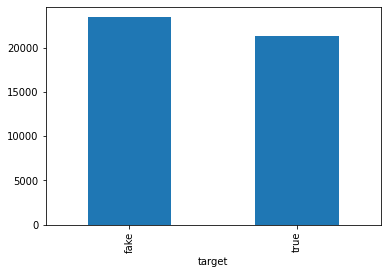

In [84]:
from pandas.core.accessor import PandasDelegate
print(df.groupby(['target'])['text'].count())
df.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [85]:
import string
def punctuation(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
df['text'] = df['text'].apply(punctuation)

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


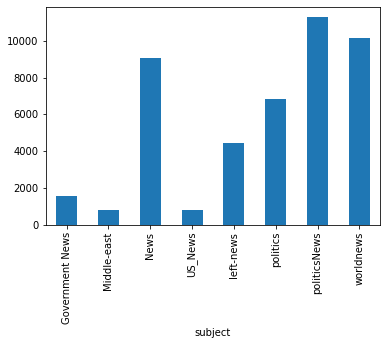

In [86]:
print(df.groupby(['subject'])['text'].count())
df.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    df['target'], test_size=0.33, random_state=42)
#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [88]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

In [89]:
def confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [90]:
title = Pipeline([
               ('imputer', TextImputer('title', '')),
               ('selector', ColumnSelector(key='title')),
                ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.9,  min_df=10))
            ])
text = Pipeline([
                ('imputer', TextImputer('text', '')),
                ('selector', ColumnSelector(key='text')),
                ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.9,  min_df=10))
            ])
subject = Pipeline([
                ('imputer', TextImputer('subject', '')),
                ('selector', ColumnSelector(key='subject')),
                ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.6, min_df=10))
            ])


feats = FeatureUnion([('title', title),
                      ('text', text),
                      ('subject', subject)
                      ])

In [91]:
features = ['title', 'text','subject']
target = 'target'

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [93]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=25, criterion="entropy")),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('title',
                                                 Pipeline(steps=[('imputer',
                                                                  TextImputer(key='title',
                                                                              value='')),
                                                                 ('selector',
                                                                  ColumnSelector(key='title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.9,
                                                                                  min_df=10,
                                                                                  stop_words='english'))])),
                                                ('text',
                                                 Pipe

In [94]:
prediction = pipeline.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.72%


Confusion matrix, without normalization
[[7756   22]
 [  20 7019]]


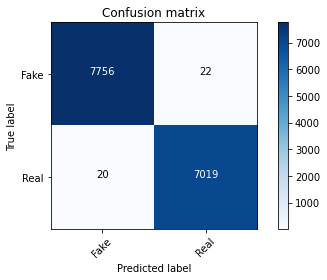

In [95]:
cm = metrics.confusion_matrix(y_test, prediction)
confusion_matrix(cm, classes=['Fake', 'Real'])

In [96]:
predictions = pipeline.predict_proba(X_test)

In [97]:
roc_auc_score(y_score=predictions[:, 1][:], y_true=y_test.iloc[:])

0.9999593328445847

In [98]:
with open("logreg_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

In [99]:
dill._dill._reverse_typemap['ClassType'] = type

In [100]:
with open('logreg_pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [101]:
def get_prediction(title, text, subject):
    body = {'title': title,
                      'text': text,
                      'subject': subject} 

    myurl = "http://0.0.0.0:8180/predict"
    req = urllib.request.Request(myurl)
    req.add_header('Content-Type', 'application/json; charset=utf-8')
    jsondata = json.dumps(body)
    jsondataasbytes = jsondata.encode('utf-8')   # needs to be bytes
    req.add_header('Content-Length', len(jsondataasbytes))
    #print (jsondataasbytes)
    response = urllib.request.urlopen(req, jsondataasbytes)
    return json.loads(response.read())['predictions']